# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

'cp' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

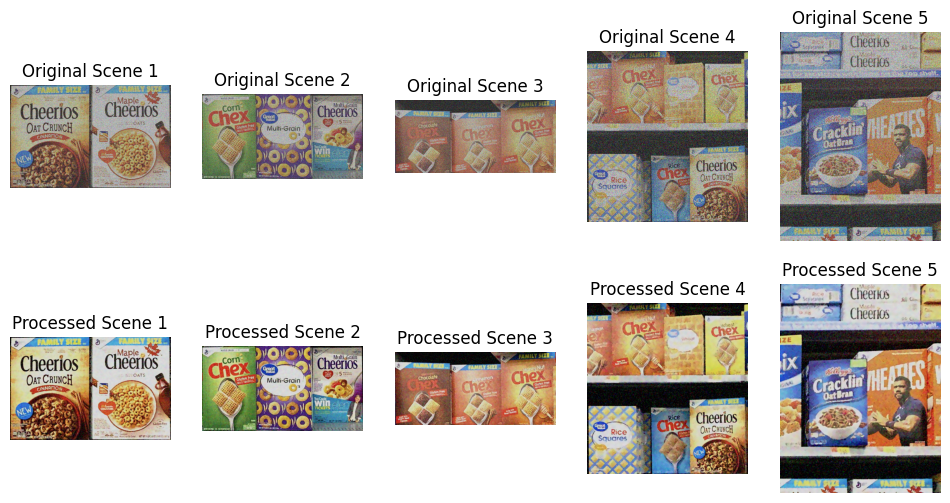

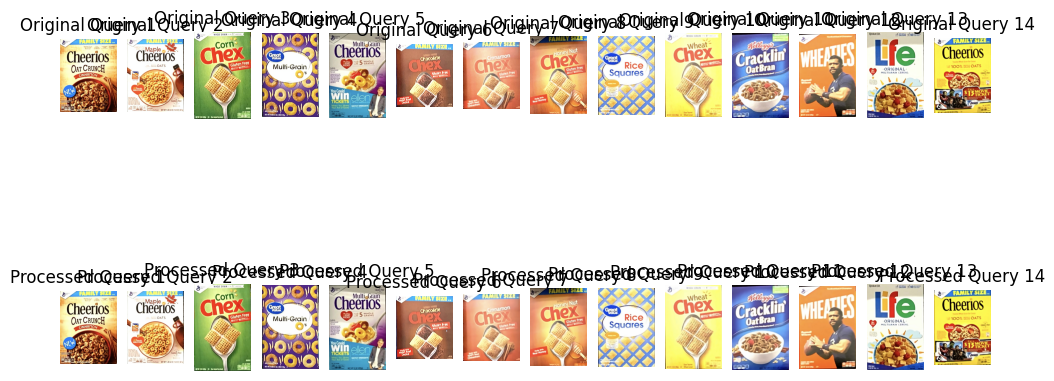

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the images from the dataset
scene_images = [cv2.imread(f'dataset/scenes/scene{i}.png') for i in range(1, 6)]
query_images = [cv2.imread(f'dataset/models/ref{i}.png') for i in range(1, 15)]

# Experiment with different kernel sizes
median_kernel_size = 5  # Kernel for median filter
gaussian_kernel_size = (5, 5)  # Kernel for Gaussian blur

# Preprocessing pipeline
def process_images(images, median_kernel_size, gaussian_kernel_size):
    """
    Preprocesses the images using a combination of filtering techniques.
    """
    # Convert from BGR to RGB
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

    # Apply median filter to remove salt-and-pepper noise
    median_filtered = [cv2.medianBlur(img, median_kernel_size) for img in images]

    # Apply Gaussian blur to reduce general blurring
    gaussian_blurred = [cv2.GaussianBlur(img, gaussian_kernel_size, 1) for img in median_filtered]

    # Apply Non-Local Means Denoising
    nlm_filtered = [cv2.fastNlMeansDenoisingColored(img, None, 12, 12, 7, 21) for img in gaussian_blurred]

    return nlm_filtered

# Sharpening filter
def sharpen_image(image):
    """
    Applies a sharpening filter to enhance edges in the image.
    """
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Apply preprocessing to scenes and query images
nlm_scenes = process_images(scene_images, median_kernel_size, gaussian_kernel_size)
scenes = [sharpen_image(img) for img in nlm_scenes]

nlm_queries = process_images(query_images, median_kernel_size, gaussian_kernel_size)
queries = [sharpen_image(img) for img in nlm_queries]

# Visualize preprocessing results
'''def visualize_preprocessing(original, processed, title):
    """
    Visualizes original and processed images for comparison.
    """
    plt.figure(figsize=(12, 6))
    for i in range(len(original)):
        plt.subplot(2, len(original), i + 1)
        plt.imshow(cv2.cvtColor(original[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Original {title} {i+1}")
        plt.axis("off")

        plt.subplot(2, len(original), i + 1 + len(original))
        plt.imshow(processed[i])
        plt.title(f"Processed {title} {i+1}")
        plt.axis("off")
    plt.show()

# Visualize scenes
visualize_preprocessing(scene_images, scenes, "Scene")

# Visualize queries
visualize_preprocessing(query_images, queries, "Query")
'''


In [4]:
# color hist

def get_hist(img, bins=(8,8,8)):
    """
    Computes the color histogram of an image.
    """
    hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [5]:
def plot_histogram(hist, title, color_space='HSV'):
    # Plotting the histogram for the three channels
    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("Frequency")

    colors = ('b', 'g', 'r')
    for i, color in enumerate(colors):
        plt.plot(hist[i], color=color)
    plt.show()

def visualize_histograms(img_query, roi_train):
    # Compute histograms
    hist_query = get_hist(img_query)
    hist_roi_train = get_hist(roi_train)

    # Visualize histograms
    plot_histogram(hist_query, "Histogram for Query Image")
    plot_histogram(hist_roi_train, "Histogram for ROI in Train Image")

In [63]:
# box drawer

def draw_boxes(good, query_kp, scene_kp , query, scene, scene_i, query_i):
    #correspondence arrays for good matches
    query_pts = np.float32([query_kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    scene_pts = np.float32([scene_kp[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    #estimate homography
    H, mask = cv2.findHomography(query_pts, scene_pts, cv2.RANSAC, 5.0)

    #get the corners of the query image
    h, w = query.shape[:2]
    query_corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    #prject the corners of the query image to the scene image
    scene_corners = cv2.perspectiveTransform(query_corners, H)

    #extraxt bounding box
    coordinates = np.int32(scene_corners).reshape(-1,2)
    x,y,w,h = cv2.boundingRect(coordinates)

    #get the center of the bounding box
    center = (x+w//2, y+h//2)

    #check the number of good matches
    if len(good) < 100:
        #ROI CHECKING 
        scene_roi = scene[y:y+h, x:x+w]
        if scene_roi.size == 0:
            return []
        
        hist_treshold = 0.4

        #visualize_histograms(query, scene_roi, query_i, scene_i)

        query_hist = get_hist(query)
        scene_roi_hist = get_hist(scene_roi)

        similarity = cv2.compareHist(query_hist, scene_roi_hist, cv2.HISTCMP_CORREL)

        if similarity < hist_treshold:
            return []
    
    print("Instance {} found in scene {} in position: ({}, {}), width: {}px, height: {}px".format(query_i, scene_i, center[0], center[1], w, h))
    print("Number of good matches: ", len(good))
    #draw the bounding box
    scene_copy = scene.copy()
    scene_copy = cv2.polylines(scene_copy,[np.int32(scene_corners)],True,(255, 255, 0),10, cv2.LINE_AA)
    scene_copy = cv2.circle(scene_copy, center, 10, (255, 255, 0), -1)
    return scene_copy


In [66]:
# lowe ratio function

def lowe_ratio(matches, min, query_kp, scene_kp , query, scene, scene_i, query_i, ratio=0.75):

    good_matches = []
    for m, n in matches:
        if m.distance < 0.68*n.distance:
            good_matches.append(m)



    # check if the number of good matches is greater than the minimum required
    if len(good_matches) >= 50:
        scene_img = draw_boxes(good_matches, query_kp, scene_kp , query, scene, scene_i, query_i)
        if(len(scene_img) == 0):
            return -1
        
        fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]})
        axes[0].imshow(query)
        axes[0].axis('off')
        axes[0].set_title('Query')

        axes[1].imshow(scene_img)
        axes[1].axis('off')
        axes[1].set_title('Scene')
        plt.show()
        return len(matches)
    else:
        return -1


In [61]:
# main function of track A (SIFT)

def track_A(scene, query, min, scene_i, query_i):

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors for scene and query images
    scene_kp, scene_des = sift.detectAndCompute(scene,  None)
    query_kp, query_des = sift.detectAndCompute(query, None)

    # Initialize FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 55)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    matches = flann.knnMatch(query_des, scene_des, k=2)

    found = lowe_ratio(matches, min, query_kp, scene_kp , query, scene, scene_i, query_i)
    return found


Instance 1 found in scene 1 in position: (412, 539), width: 805px, height: 1052px
Number of good matches:  579


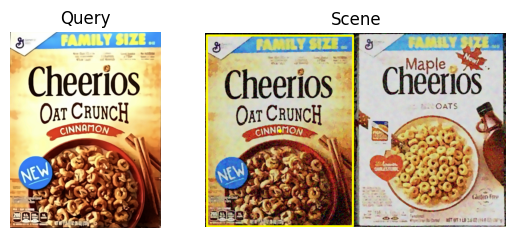

Instance 2 found in scene 1 in position: (1248, 534), width: 804px, height: 1050px
Number of good matches:  470


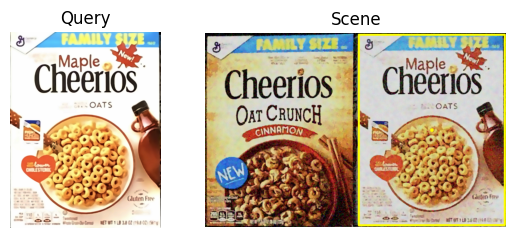

Instance 3 found in scene 2 in position: (306, 493), width: 607px, height: 944px
Number of good matches:  272


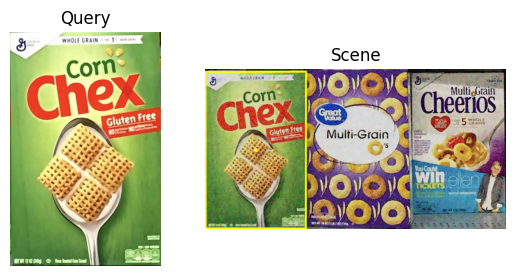

Instance 4 found in scene 2 in position: (928, 483), width: 636px, height: 952px
Number of good matches:  226


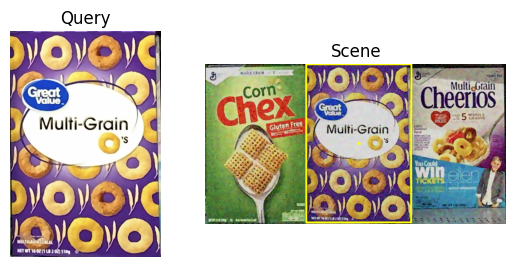

Instance 5 found in scene 2 in position: (1529, 450), width: 562px, height: 845px
Number of good matches:  312


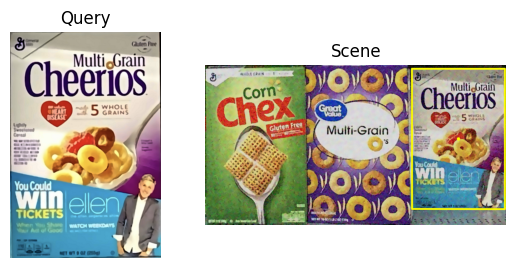

Instance 6 found in scene 3 in position: (299, 459), width: 603px, height: 672px
Number of good matches:  100


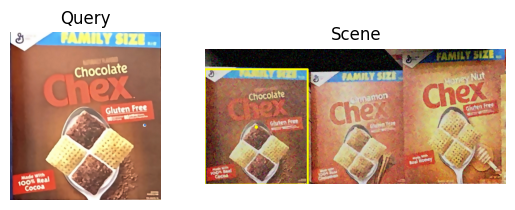

Instance 7 found in scene 3 in position: (889, 461), width: 547px, height: 651px
Number of good matches:  96


Instance 8 found in scene 3 in position: (1447, 398), width: 561px, height: 781px
Number of good matches:  169


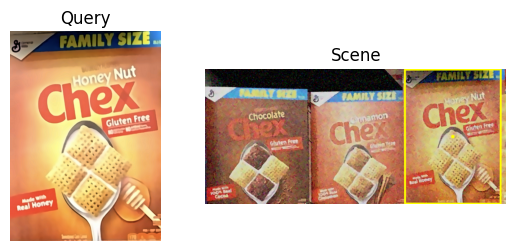

Instance 1 found in scene 4 in position: (888, 912), width: 383px, height: 517px
Number of good matches:  214


Instance 8 found in scene 4 in position: (350, 258), width: 351px, height: 492px
Number of good matches:  65


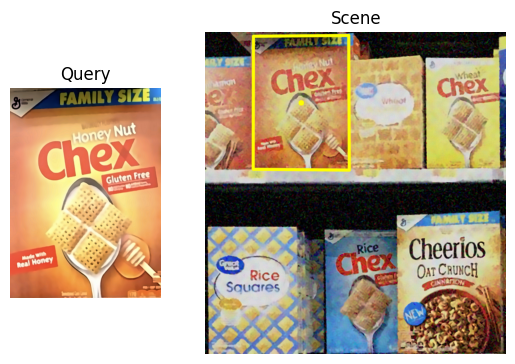

Instance 9 found in scene 4 in position: (174, 943), width: 329px, height: 468px
Number of good matches:  62


Instance 10 found in scene 4 in position: (937, 293), width: 272px, height: 407px
Number of good matches:  51


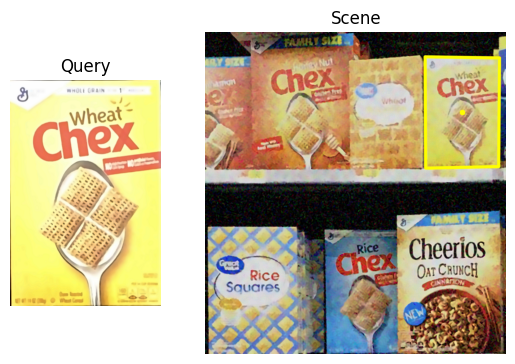

Instance 11 found in scene 5 in position: (368, 751), width: 369px, height: 557px
Number of good matches:  158


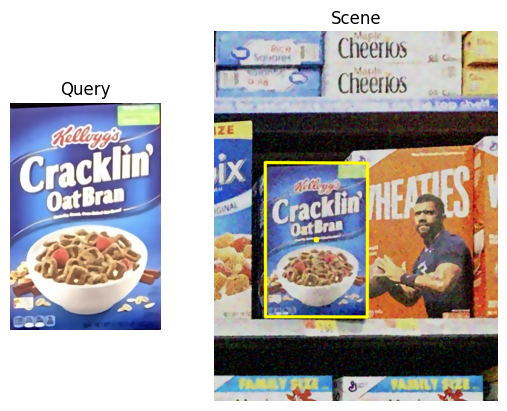

Instance 12 found in scene 5 in position: (716, 739), width: 442px, height: 658px
Number of good matches:  78


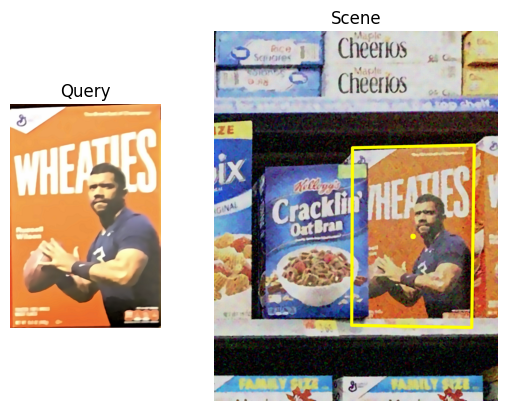

In [67]:
for i, scene_img in enumerate(scenes):
    for j, query_img in enumerate(queries):
        found = track_A(scene_img,query_img, 50, i+1, j+1) 